## 1. Select and document key parameters/columns

| Column / Tag              | Description / Notes                                        |
|---------------------------|------------------------------------------------------------|
| clinic_id / osmid         | Unique OSM identifier for the object.                      |
| clinic_name / name        | Clinic name.                                               |
| amenity                   | Should be `veterinary` for all rows.                       |
| street / addr:street      | Street name.                                               |
| house_number / addr:housenumber | House number.                                        |
| postcode / addr:postcode  | Postal code.                                               |
| city / addr:city          | City/locality.                                             |
| district_id (FK)          | District in which the clinic is located.                   |
| neighbourhood_id (FK)     | Neighbourhood in which the clinic is located.              |
| phone_number / phone      | Contact phone number(s).                                   |
| website                   | Website URL.                                               |
| email                     | E-mail address.                                            |
| opening_hours             | Structured opening hours.                                  |
| operator                  | Organisation running the clinic.                           |
| speciality                | Specialisation on certain topics.                          |
| wheelchair_acces          | Yes, no, or limited access granted.                        |
| full_address              | Full address instead of separate street/number/code/city.  |
| latitude                  | Point or polygon geometry (latitude).                      |
| longitude                 | Point or polygon geometry (longitude).                     |


## 2. Define how this data connects to existing tables

| Existing Table                                | Connection Logic                                                                                             |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Districts** (Berlin’s administrative areas) | Spatial join: point-in-polygon from clinic geometry to district polygon. Add `district_id` foreign key.      |
| **Neighborhoods**                             | Same: spatial join from clinic geometry to neighborhood boundary polygon. Add `neighborhood_id` foreign key. |


## 3. Draft and document the planned schema for the new table.


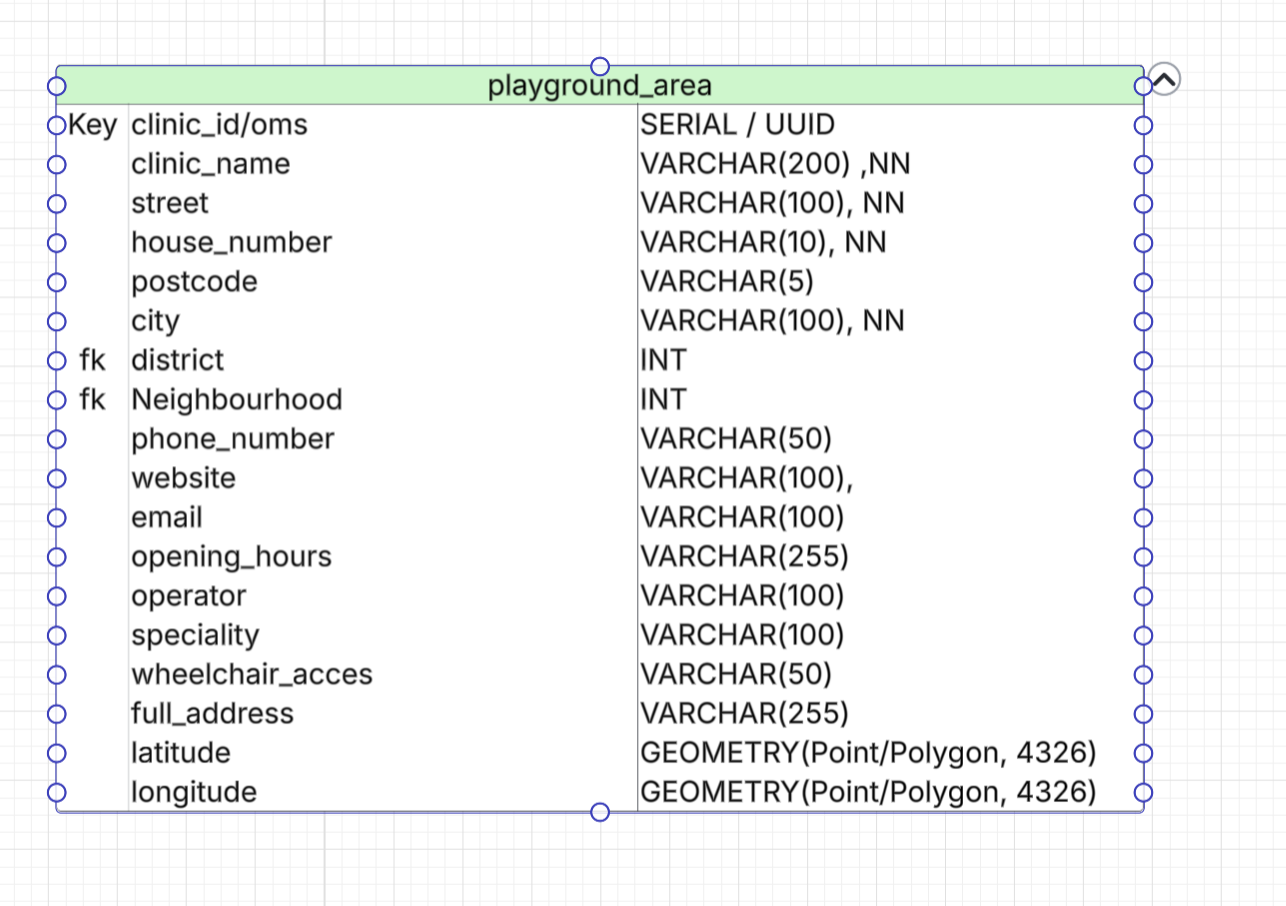

In [6]:
from IPython.display import Image, display

# Display a JPEG image from a file path or URL
display(Image(filename='/Users/martinsvitek/layered-populate-data-pool-da/layered-populate-data-pool-da/vet_clinics/sources/erd_vet_clinics.png'))


In [5]:
import os
print(os.getcwd())


/Users/martinsvitek/layered-populate-data-pool-da/layered-populate-data-pool-da/vet_clinics/sources



## 4. List known data issues or inconsistencies

Typical for OSM-derived data:

-   **Missing values**: Many clinics lack `addr:housenumber`, `phone`, `website`, or `opening_hours`.
    
-   **Multiple tags**: Phone numbers may appear under `phone` or `contact:phone`; same for website and email.
    
-   **Format differences**: Phone numbers and postcodes in different formats (international codes, hyphens, spaces).
    
-   **Duplicate entries**: Some clinics may be mapped twice (once as a node and once as a building polygon).
    
-   **Geometry types**: Some records are points, others polygons; you may need to normalize to a centroid for joins.
    
-   **Outdated information**: OSM data is crowd-sourced; closures or relocations may not be reflected immediately.
    
-   **Spelling/normalization**: Names and operators may be spelled inconsistently.
    

----------


## 5. Outline the transformation plan (cleaning, normalization, structure, etc.)

# 0) Ingestion & scope

-   Ingest via OSMnx (2.x): `ox.features_from_place('Berlin, Germany', tags={'amenity':'veterinary'})`
    
-   Keep nodes + ways/relations (ways/relations → polygon/centroid handling below)
    
-   Snapshot & cache the raw pull (parquet/geojson) for reproducibility
    
    

# 1) Column pruning & renaming

**Keep**: `osmid, name, amenity, addr:street, addr:housenumber, addr:postcode, addr:city, phone, contact:phone, website, contact:website, email, contact:email, opening_hours, operator, brand, veterinary:speciality, wheelchair, emergency, geometry`

**Rename → target schema**

-   `clinic_id/osmid` ← `osmid`
    
-   `clinic_name/name` ← `name`
    
-   `street` ← `addr:street`
    
-   `house_number` ← `addr:housenumber`   
-   `postcode` ← `addr:postcode`   
-   `city` ← `addr:city`
-    `district_id`
-    `neighbourhood_id`    
-   `phone_number` ← coalesce(`contact:phone`, `phone`)   
-   `website` ← coalesce(`contact:website`, `website`)  
-   `email` ← coalesce(`contact:email`, `email`)
-    `opening_hours`
-    `operator`    
-   `speciality` ← `veterinary:speciality`    
-   `wheelchair_acces` ← `wheelchair`
-    `full_address`
-    `latitude`
-    `longitude`    
-   `amenity` should be `veterinary` (filter check)
    

# 2) Geometry normalization

-   If geometry is **Point** → keep
    
-   If **Polygon/MultiPolygon** → compute centroid for point-based joins/analysis; retain original geometry if you need building footprint later
    
-   Set CRS to EPSG:4326
    

# 3) Data cleaning

**Strings**

-   Strip whitespace, normalize Unicode, collapse repeated spaces  
-   Lowercase only when appropriate (not for proper names/streets)   

**Phone**

-   Canonicalize: remove spaces/dashes, keep leading `+` if present   
-   Optional: format to E.164 if country is known (DE → `+49`)   

**Website**

-   Ensure scheme: prepend `https://` if missing; drop obvious junk
    

**Email**

-   Basic pattern check; lowercase domain    

**Postcode**

-   Keep as text; left-pad if needed (e.g., 5 digits for DE) not sure about this yet, postalcode as number for search
    
**opening_hours**

-   Keep raw string; optionally validate with an opening-hours parser (e.g., `pyopening_hours`)    

**operator/brand**

-   Trim, title-case; prepare for reference matching
    

**wheelchair/emergency**

-   Map to controlled set: `yes | no | limited` and `yes | no`
    

# 4) De-duplication

-   Node vs polygon duplicates:
    
    -   Spatial proximity (<= 20–30 m) **and** name similarity (e.g., fuzzy ratio ≥ 90) → treat as same clinic
        
    -   Prefer the polygon record for address context, but keep the point geometry for joins/labeling
        
-   Exact duplicates on `osmid` → drop
    

# 5) Address enrichment & full address

-   Build `full_address` as:
    
    -   `"{street} {house_number}, {postcode} {city}"` (only include non-null parts, single spaces/commas)
        

# 6) Spatial keys (district / neighbourhood)

-   Load official Berlin **districts** and **Ortsteile** boundaries (CRS: 4326)
    
-   **Point-in-polygon** with centroid:
    
    -   assign `district_id`, `neighbourhood_id`
        
-   If outside any polygon: flag `geo_out_of_bounds = true` for QA
    

# 7) Conformance to target schema

-   Types (example, PostgreSQL/PostGIS):
    
    -   `clinic_id` → UUID (or `osmid` BIGINT as natural key)
        
    -   `clinic_name` → `VARCHAR(200)` NN if required
        
    -   address fields → `VARCHAR`
        
    -   `phone_number` → `VARCHAR(50)`
        
    -   `website`, `email` → `VARCHAR(255)`
        
    -   `opening_hours` → `VARCHAR(255)`
        
    -   FK: `district_id`, `neighbourhood_id` → `INT` (reference tables)
        
    -   `geometry` → `GEOMETRY(Point, 4326)`
        
-   Create functional indexes:
    
    -   `GIN`/`btree` on `operator`, `postcode`, `district_id`
        
    -   `GIST` on `geometry`
        

# 8) Business rules & validations (tests)

-   **Amenity check**: all rows must have `amenity = 'veterinary'`
    
-   **Not-nulls** (decide policy): `clinic_id`, `geometry`, `city`
    
-   **Phone**: only digits, spaces, `+`, `()` and `-`
    
-   **Website**: must start with `http` or be null
    
-   **Opening hours**: parseable or null
    
-   **Spatial**: 100% within Berlin districts unless flagged
    
-   **Duplicates**: post-dedupe no pairs within X m with same normalized name
    

# 9) Operators reference table (optional)

-   Build `operators(dim)` with `operator_id`, `operator_name`, `brand`
    
-   Match clinics → `operator_id` by normalized `operator/brand`
    
-   Handle “unknown” bucket
    

# 10) Output artifacts

-   **Gold table**: `marts.vet_clinics` (one row per clinic, point geometry)
    
-   **Supplement**: `marts.vet_clinics_areas` (optional polygon footprints)
    
-   **Exports**: CSV (no geometry), GeoJSON (with geometry)
    

# 11) Known issues to track

-   Missing address/contact/opening_hours on many rows
    
-   Node/area duplication
    
-   Informal neighborhood vs official Ortsteil boundaries
    
-   Outdated listings (closures/moves)
    
-   Inconsistent phone and website formats
    
-   Specialities free-text & multilingual
    
-   Wheelchair/emergency incompletely tagged
    

----------


```

**Spatial join (concept)**

-   Load districts & neighbourhoods as GeoDataFrames
    
-   `gpd.sjoin(gdf.set_geometry('geometry'), districts, how='left', predicate='within')`
    
-   Assign `district_id`, then repeat for neighbourhoods
    

----------

## Acceptance criteria (quick checklist)

-   100% `amenity='veterinary'`
    
-   No duplicate clinics (name+distance rule)
    
-   ≥ X% rows have `street` + `housenumber` + `postcode` + `city`
    
-   Validated `website`/`email` formats
    
-   `district_id` & `neighbourhood_id` populated for ≥ 99% of points
    
-   Geometry CRS is EPSG:4326; centroids used for polygons
    
-   Exports produced: CSV (attribs), GeoJSON (with geometry)
    



----------